In [623]:
import pandas as pd
#import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
#import shapely
import math
import os
from collections import OrderedDict
from EM_Tomo_viz_tools import *
from Create_vector_grid import *
%matplotlib inline
pd.options.mode.chained_assignment = None


In [724]:
#Settings:
depth = 3
no_data_value = float('Nan')
input_file2 = "/Users/kazv/VanBovenDrive/VanBoven MT/500 Projects/P2 Wiertsema/data/3D_compleet.shp"
output_file2 = "/Users/kazv/VanBovenDrive/VanBoven MT/500 Projects/P2 Wiertsema/data/Test_output.shp"


In [706]:
#Read and upgrade basic GDF:
gdf = read_shapefile(input_file2)
gdf['top'] = gdf.elev_boven
gdf['bottom'] = gdf.elev_boven+gdf.Dikte


In [707]:
#Filter for the right depth and create new GDF with 'Meetlocatie' ID as index
gdf_filtered = gdf[(gdf.top> -depth) & (gdf.bottom < -depth)]
gdf_filtered['Punt_ID_num'] = gdf_filtered.Punt_ID.apply(lambda x: int(x[x.find('_')+1::]))
gdf_filtered.sort_values('Punt_ID_num', inplace=True)
gdf_filtered.set_index('Punt_ID_num', drop=True, inplace=True)
gdf_filtered.drop('Punt_ID',1,inplace=True)

#Determine grid size by using distance between measurements
gdf_filtered['dist_to_next'] = gdf_filtered.distance(gdf_filtered.shift(1))
grid_size = int(gdf_filtered.dist_to_next.median())+1 #+1 to make sure we slightly over-sample

In [708]:
#Create the grid
xmin,ymin,xmax,ymax = gdf_filtered.geometry.total_bounds

length = grid_size
wide = grid_size

cols = list(range(int(np.floor(xmin)-wide), int(np.ceil(xmax)+wide), wide))
rows = list(range(int(np.floor(ymin)-length), int(np.ceil(ymax)+length), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.crs = gdf_filtered.crs
#translate grid so that points fall in the center instead of at the boundaries
grid.geometry = grid.geometry.translate(xoff=int(grid_size/2), yoff=int(grid_size/2))

In [709]:
#Join raster with measurement points to find out which points lie in every raster element
joined_raster_data = gpd.sjoin(grid,gdf_filtered, how="left")

In [710]:
grid_data = gpd.GeoDataFrame()
grid_data['geometry'] = grid.geometry
grid_data['IDs'] = joined_raster_data.groupby(joined_raster_data.index).index_right.apply(list)
grid_data['has_data'] = grid_data.IDs.apply(lambda x: x[0] == x[0])
grid_data['EC'] = no_data_value
grid_data['depth'] = depth


In [711]:
#Determine right 'average' EC value, based on proximity to centroid.
#This could be extended to include empty as well by interpolation.
#TODO: Add concave hull boundary to detect which 'novalues' should remain 'novalue' and interpolate the others.
for ii in range(1,len(grid_data)):
    line = grid_data.iloc[ii]
    if line.has_data:
        id_list = line.IDs
        #Get all measurements within the square
        this_square_df =gdf_filtered[gdf_filtered.index.isin(id_list)]
        centroid = line.geometry.centroid
        #Determine distance (and inverse) to centroid
        this_square_df['dist_to_centroid'] = this_square_df.geometry.distance(centroid)
        this_square_df['closeness'] = 1/this_square_df.dist_to_centroid
        #take weighted average of EC with respect to closeness to centroid. 
        #The closer the higher its weighted in a linear fashion.
        this_square_df['weighted_EC'] = this_square_df.EC * this_square_df.closeness
        weighted_avg_EC = this_square_df.weighted_EC.sum()/this_square_df.closeness.sum()
        grid_data['EC'][grid_data.index==ii] = weighted_avg_EC


In [725]:
#generate requested output
output = grid_data[['geometry','EC','depth']]
output.to_file(driver = 'ESRI Shapefile', filename = output_file2)

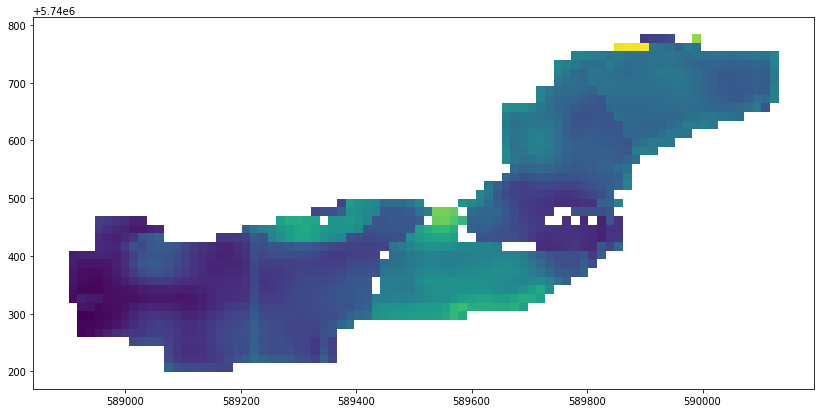

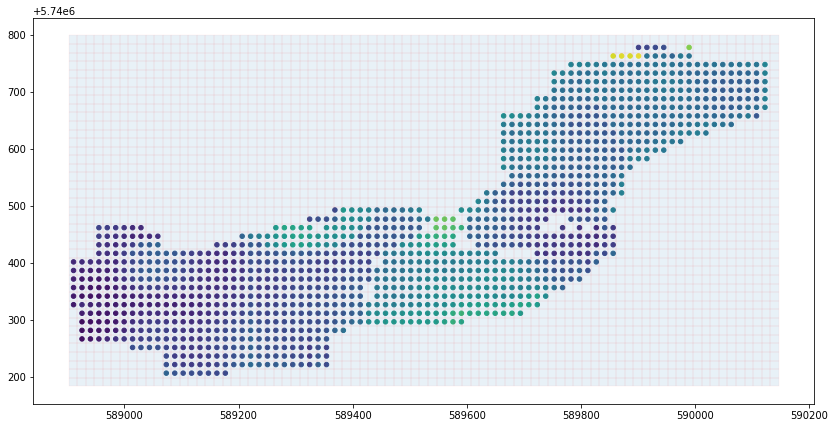

In [718]:
#Optional plotting for reference
grid_data[grid_data.EC>0].plot(column = 'EC', figsize=(14,10))
data_plot = gdf_filtered.plot(column='EC', markersize=20, figsize=(14,10))
grid.plot(ax=data_plot,alpha=0.1, edgecolor="red", linewidth=0.4)